In [1]:
import os
import sys

import pandas as pd
import torch

In [2]:
# Add the parent directory of 'src' to sys.path if not already present
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import src.assimilation.assimilator  # noqa: E402
import src.assimilation.test_configs  # noqa: E402, F401

In [3]:
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt

mpl.rcParams["text.usetex"] = True
mpl.rc("text.latex", preamble=r"\usepackage{amsmath}")

In [4]:
SAVE_ROOT = "../ass_results/assimilate_various_obs_freq_no_fdc"

pickle_cache_path = "./plot_various_obs_freq_no_fdc.pkl"

read_cache = True

try:
    assert read_cache
    results = pd.read_pickle(pickle_cache_path)
except:  # noqa: E722
    entries = []
    for filename in os.listdir(SAVE_ROOT):
        if filename.endswith(".pt"):
            file_path = os.path.join(SAVE_ROOT, filename)
            print(file_path)
            saved_data = torch.load(file_path, weights_only=False)
            entry = pd.DataFrame(
                {
                    "obs_type": saved_data["obs_type"][0],
                    "method": saved_data["method"],
                    "rand_mask_ratio": saved_data["rand_mask_ratio"],
                    "seed_no": saved_data["seedno"],
                    "rmse": saved_data["rmse"],
                    "step_idx": range(len(saved_data["rmse"])),
                    "time_stride": saved_data["time_stride"],
                    "avg_rmse": sum(saved_data["rmse"]) / len(saved_data["rmse"]),
                }
            )
            entries.append(entry)
    results = pd.concat(entries)
    results.to_pickle(pickle_cache_path)

In [5]:
results

,obs_type,method,rand_mask_ratio,seed_no,rmse,step_idx,time_stride,avg_rmse
0,vor2vel,soad,1.0,0,0.151907,0,1,0.134137
1,vor2vel,soad,1.0,0,0.143385,1,1,0.134137
2,vor2vel,soad,1.0,0,0.137011,2,1,0.134137
3,vor2vel,soad,1.0,0,0.132130,3,1,0.134137
4,vor2vel,soad,1.0,0,0.129087,4,1,0.134137
...,...,...,...,...,...,...,...,...
4,sin3x,soad,10.0,4,1.576522,4,8,1.570744
5,sin3x,soad,10.0,4,1.579129,5,8,1.570744
6,sin3x,soad,10.0,4,1.578719,6,8,1.570744
7,sin3x,soad,10.0,4,1.577275,7,8,1.570744


In [6]:
count_keys = ["obs_type", "method", "rand_mask_ratio", "time_stride", "seed_no"]
for key in count_keys:
    print(key, ":", sorted(results[key].unique()))

obs_type : ['arctan3x', 'sin3x', 'vor2vel']
method : ['soad']
rand_mask_ratio : [np.float64(0.01), np.float64(0.0625), np.float64(0.25), np.float64(1.0), np.float64(2.0), np.float64(4.0), np.float64(10.0)]
time_stride : [np.int64(1), np.int64(2), np.int64(4), np.int64(8)]
seed_no : [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [7]:
df = results

In [8]:
arctan3x = df[df["obs_type"] == "arctan3x"]
sin3x = df[df["obs_type"] == "sin3x"]
vor2vel = df[df["obs_type"] == "vor2vel"]

In [9]:
arctan3x_sda = arctan3x[arctan3x["method"] == "sda"]
arctan3x_soad = arctan3x[arctan3x["method"] == "soad"]

sin3x_sda = sin3x[sin3x["method"] == "sda"]
sin3x_soad = sin3x[sin3x["method"] == "soad"]

vor2vel_sda = vor2vel[vor2vel["method"] == "sda"]
vor2vel_soad = vor2vel[vor2vel["method"] == "soad"]

In [10]:
palette = ["#420802", "#822E24", "#C27067", "#FFCDC7"]
palette = ["#42040B", "#822833", "#C26D76", "#FFCFD4"]
palette = ["#2A3332", "#37615C", "#33A194", "#0FE0C8"]
palette = ["#0D3320", "#306149", "#78A18D", "#B4E0CA"]
palette = ["#072433", "#244D61", "#648CA1", "#D1DBE0"]
palette = ["#060933", "#242861", "#6468A1", "#D1D2E0"]
palette = ["#7B7AD6", "#E08D89", "#E0D189", "#89E1AB"]
# palette = ['#8CB1FF', '#FF82B9', '#FFDC8C', '#8DFF91']
palette = sns.palettes.color_palette(palette)

In [11]:
grouped = arctan3x.groupby(["rand_mask_ratio", "step_idx", "time_stride"])
f = grouped.agg({"rmse": ["mean", "std"]})
f

rmse          
                                          mean       std
rand_mask_ratio step_idx time_stride                    
0.01            0        1            0.910334  0.028156
                         2            0.956701  0.028145
                         4            1.000157  0.024806
                         8            1.046661  0.020291
                1        1            0.907302  0.028885
...                                        ...       ...
10.00           7        8            0.923887  0.004731
                8        1            0.779337  0.007366
                         2            0.835785  0.005717
                         4            0.884166  0.007581
                         8            0.928046  0.003750

[252 rows x 2 columns]

In [12]:
def plot_avg_cases(x: pd.DataFrame, save_path: str):
    grouped = x.groupby(["rand_mask_ratio", "step_idx", "time_stride"])
    f = grouped.agg({"rmse": ["mean", "std"]})
    ff = f.groupby(["rand_mask_ratio", "time_stride"]).mean()
    ff = ff.reset_index()
    df_pivot = ff.pivot_table(index="rand_mask_ratio", columns="time_stride", values="rmse").drop(columns="std")
    print(df_pivot)

    vmin, vmax = (0.05, 0.5)  # if 'arctan' in save_path else (0., 1.)

    cmap = sns.color_palette("Blues", as_cmap=True)
    cmap.set_over("slategray")

    ax = sns.heatmap(
        df_pivot,
        annot=True,
        annot_kws={"size": 12},
        fmt=".3f",
        linewidths=0.5,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar_kws={"extend": "max", "label": "RMSE"},
    )

    ax.set_yticklabels(["$p=0.01$", "$p=0.0625$", "$p=0.25$", "$s=p=1$", "$s=2$", "$s=4$", "$s=10$"], rotation=0)
    ax.set_xticklabels(["$N=1$", "$N=2$", "$N=4$", "$N=8$"], rotation=45)
    ax.set_ylabel("")
    ax.set_xlabel("")
    plt.savefig(save_path)

                     mean                              
time_stride             1         2         4         8
rand_mask_ratio                                        
0.0100           0.908271  0.955069  0.998155  1.043564
0.0625           0.451855  0.518295  0.578584  0.631838
0.2500           0.258798  0.313658  0.374764  0.431719
1.0000           0.154861  0.181860  0.215303  0.256393
2.0000           0.249240  0.304159  0.362245  0.420143
4.0000           0.426584  0.496583  0.559532  0.611357
10.0000          0.765717  0.821896  0.873164  0.918907


/tmp/ipykernel_673582/1833239447.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_pivot = ff.pivot_table(index="rand_mask_ratio", columns="time_stride", values="rmse").drop(columns="std")


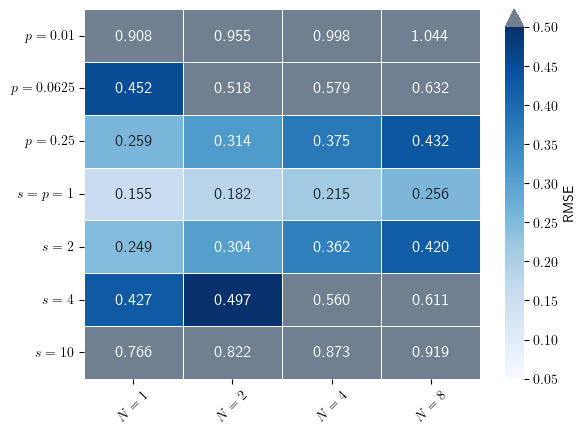

In [13]:
plot_avg_cases(arctan3x_soad, save_path="../figs/assimilate_with_prior_arctan3x_soad_no_fdc_heatmap.pdf")

/tmp/ipykernel_673582/1833239447.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_pivot = ff.pivot_table(index="rand_mask_ratio", columns="time_stride", values="rmse").drop(columns="std")


                     mean                              
time_stride             1         2         4         8
rand_mask_ratio                                        
0.0100           1.471831  1.488998  1.518988  1.525403
0.0625           1.295660  1.382689  1.454407  1.506164
0.2500           0.824169  0.995474  1.158186  1.320980
1.0000           0.702747  0.456182  0.634947  0.902521
2.0000           0.739602  0.978228  1.156605  1.303745
4.0000           1.299798  1.414727  1.494558  1.548198
10.0000          1.493052  1.518195  1.526304  1.533627


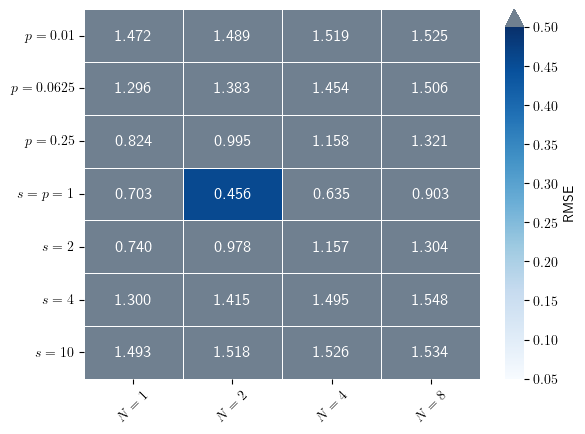

In [14]:
plot_avg_cases(sin3x_soad, save_path="../figs/assimilate_with_prior_sin3x_soad_no_fdc_heatmap.pdf")

/tmp/ipykernel_673582/1833239447.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_pivot = ff.pivot_table(index="rand_mask_ratio", columns="time_stride", values="rmse").drop(columns="std")


                     mean                              
time_stride             1         2         4         8
rand_mask_ratio                                        
0.0100           0.534703  0.593152  0.650969  0.712124
0.0625           0.293757  0.341363  0.392419  0.437436
0.2500           0.193669  0.224276  0.257851  0.290023
1.0000           0.134714  0.155307  0.176071  0.197043
2.0000           0.190708  0.221663  0.255409  0.287964
4.0000           0.283236  0.332817  0.384827  0.430535
10.0000          0.491998  0.555599  0.617887  0.672812


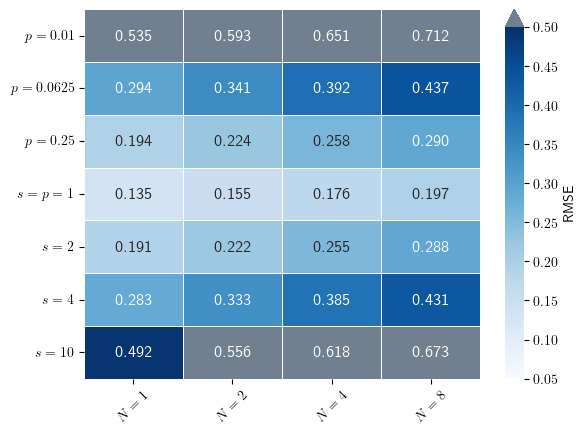

In [15]:
plot_avg_cases(vor2vel_soad, save_path="../figs/assimilate_with_prior_vor2vel_soad_no_fdc_heatmap.pdf")